# Experiments on vanilla NADE(Neural Autoregressive Density Estimation)
* [paper](http://proceedings.mlr.press/v15/larochelle11a/larochelle11a.pdf)
* GPU is enabled: 
> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/drive/1tzlvd-fzBgRP0-rhSePW9Fyq6B_RSnN3?usp=sharing">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href=""><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

# 01. Set-up

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
cd /content/gdrive/MyDrive/colab-github/STAT37792

/content/gdrive/MyDrive/colab-github/STAT37792


### Dataset: Binarized MNIST

In [14]:
"""Extra generative modeling benchmark datasets not provided by PyTorch."""

import os
import urllib

import PIL
import numpy as np
import torch
from torch import distributions
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import utils
from torchvision.datasets import vision

def _dynamically_binarize(x):
    return distributions.Bernoulli(probs=x).sample()


def _resize_to_32(x):
    return F.pad(x, (2, 2, 2, 2))

    
def get_mnist_loaders(batch_size, dynamically_binarize=False, resize_to_32=False):
    """Create train and test loaders for the MNIST dataset.
    Args:
        batch_size: The batch size to use.
        dynamically_binarize: Whether to dynamically  binarize images values to {0, 1}.
        resize_to_32: Whether to resize the images to 32x32.
    Returns:
        Tuple of (train_loader, test_loader).
    """
    transform = [transforms.ToTensor()]
    if dynamically_binarize:
        transform.append(_dynamically_binarize)
    if resize_to_32:
        transform.append(_resize_to_32)
    transform = transforms.Compose(transform)
    train_loader = data.DataLoader(
        datasets.MNIST("/tmp/data", train=True, download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=os.cpu_count(),
    )
    test_loader = data.DataLoader(
        datasets.MNIST("/tmp/data", train=False, download=True, transform=transform),
        batch_size=batch_size,
        num_workers=os.cpu_count(),
    )
    return train_loader, test_loader

In [15]:
train_loader, test_loader = get_mnist_loaders(batch_size = 512, dynamically_binarize=True)

In [16]:
for image, label  in train_loader:
  sample = image[0:10]
  sample_label = label[0:10]

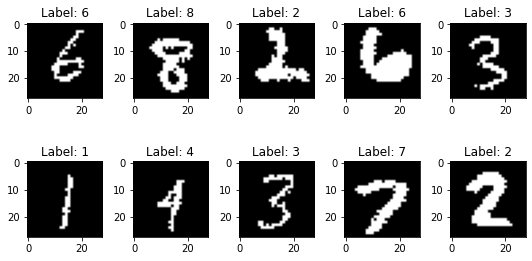

In [17]:
import matplotlib.pyplot as plt

num = 10
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(sample_label[i]))
plt.tight_layout()
plt.show()

# 02. NADE architecture

In [18]:
import torch

In [19]:
import numpy as np
np.random.seed(1234)
dim_list = np.arange(784)
np.random.shuffle(dim_list)

In [20]:
import torch
from torch import distributions
from torch import nn


class NADE(torch.nn.Module):
    """The Neural Autoregressive Distribution Estimator (NADE) model."""

    def __init__(self, input_dim, hidden_dim):
        """Initializes a new NADE instance.

        Args:
            input_dim: The dimension of the input.
            hidden_dim: The dimmension of the hidden layer. NADE only supports one
                hidden layer.
        """
        super().__init__()
        self._input_dim = input_dim

        # fmt: off
        self._W = nn.Parameter(torch.zeros(hidden_dim, self._input_dim))
        self._c = nn.Parameter(torch.zeros(hidden_dim,))
        self._V = nn.Parameter(torch.zeros(self._input_dim, hidden_dim))
        self._b = nn.Parameter(torch.zeros(self._input_dim,))
        # fmt: on
        nn.init.kaiming_normal_(self._W)
        nn.init.kaiming_normal_(self._V)
        

    def forward(self, x, order):
        """Computes the forward pass and samples a new output.

        Returns:
            (p_hat, x_hat) where p_hat is the probability distribution over dimensions
            and x_hat is sampled from p_hat.
        """

        eps = 1e-15 
        # If the input is an image, flatten it during the forward pass.
        original_shape = x.shape
        if len(x.shape) > 2:
            x = x.view(original_shape[0], -1)
        # fix the order
        x = x[:,order]
        
        p_hat, x_hat = [], []
        batch_size = 1 if x is None else x.shape[0]
        # Only the bias is used to compute the first hidden unit so we must replicate it
        # to account for the batch size.
        a = self._c.expand(batch_size, -1)
        p = 1
        logp = 0
        for i in range(self._input_dim):
            h = torch.sigmoid(a)
            p_i = torch.sigmoid(h @ self._V[i : i + 1, :].t() + self._b[i : i + 1])
            p_hat.append(p_i)

            # Sample 'x' at dimension 'i' if it is not given.
            x_i = x[:, i : i + 1]
            logp = logp + x_i*torch.log(p_i+eps)+(1-x_i)*torch.log(1-p_i+eps)

            # We do not need to add self._in_b[i:i+1] when computing the other hidden
            # units since it was already added when computing the first hidden unit.
            a = a + x_i @ self._W[:, i : i + 1].t()

        return torch.cat(p_hat, dim=1).view(original_shape), logp


Based on the code given written by Hugo Larochelle, updates have been made to run using torch.

# 03. Training

In [26]:
model = NADE(input_dim = 784, hidden_dim = 500)

In [27]:
from torch import optim
from torch.nn import functional as F

n_epochs=50
batch_size=512
debug_loader=None

In [28]:
def loss_fn(x, _, preds):
    batch_size = x.shape[0]
    x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1))
    loss = F.binary_cross_entropy(preds, x, reduction="none")
    return loss.sum(dim=1).mean()

In [29]:
optimizer = optim.SGD(model.parameters(),lr = 0.01)

In [30]:
loss =[]
for epoch in range(n_epochs):
  for i, batch in enumerate(train_loader):
    batch = batch if isinstance(batch, (tuple, list)) else (batch, None)
    x, y = batch
    out, _ = model(x, dim_list)
    loss_tmp = loss_fn(out,_, x)
    if i%10 == 0 :
       print("num_iter: %d, Loss: %.10f" %(i, loss_tmp))
    optimizer.zero_grad()
    loss_tmp.backward()
    optimizer.step() 
  

num_iter: 0, Loss: 39097.2500000000
num_iter: 10, Loss: nan


KeyboardInterrupt: ignored

In [ ]:
pwd

In [ ]:
model_trainer = Trainer(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        eval_loader=test_loader,
        log_dir="/content/gdrive/MyDrive/colab-github/STAT37792/.gitignore",
        n_gpus=1,
        device_id=0,
    )

In [ ]:
#from tensorboard import notebook
#notebook.list() # View open TensorBoard instances

# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
#notebook.display(port=6006, height=1000) 

In [ ]:
model_trainer.interleaved_train_and_eval(50)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /content/gdrive/MyDrive/colab-github/STAT37792/.gitignore

# 04. Evaluation

### 04-a. Likelihood

In [ ]:
for i, batch in enumerate(test_loader):
  batch = batch if isinstance(batch, (tuple, list)) else (batch, None)
  x, y = batch
  out = nade(x.cuda())


In [ ]:
loss_fn(x.cuda(),_,out)

### 04-b FID score
https://pytorch.org/ignite/generated/ignite.metrics.FID.html

$FID = | \mu_1 - \mu_2 | + Tr(\sigma_1 + \sigma_2 -2 \sqrt(\sigma_1 \times \sigma_2)$

In [ ]:
def calculate_activation_statistics(images,model,batch_size=500, dims=784,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
    msg = ('fid calculation produces singular product; '
            'adding %s to diagonal of cov estimates') % eps
    print(msg)
    offset = np.eye(sigma1.shape[0]) * eps
    covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

### 04-c. Sampling

In [ ]:
nade.sample(10)

# 05. Extension: What if using ReLU instead of Sigmoid?